In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML
from astroML.datasets import fetch_LINEAR_sample
from astropy.timeseries import LombScargle
from astroML.datasets import fetch_LINEAR_sample
from astroML.datasets import fetch_LINEAR_geneva
from astropy.timeseries import TimeSeries
from astropy.table import Table
from astroML.time_series import MultiTermFit

# ZTF
# from ztfquery import lightcurve

# Basic libraries
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm

# CONFIGURATION
# -------------
sns.set_theme(style='white') # setting the theme for plotting
sys.path.insert(0,'../src/')
np.random.seed(42)

# configuring plotting colors
colors = ['#465BBB', '#3F8FCE', '#7ABBCE', '#3A3865', '#A82F43', '#612A37', '#DC5433', '#F29457']
b1 = '#465BBB'
b2 = '#3F8FCE'
b3 = '#7ABBCE'
b4 = '#3A3865'
black1 = '#22212A'
black2 = '#2D1E21'
or1 = '#A82F43'
or2 = '#612A37'
or3 = '#DC5433'
or4 = '#F29457'
muted_colors = sns.set_palette(sns.color_palette(colors))

# configuring fonts for plotting
font = FontProperties()
font.set_family('serif')
font.set_name('Andale Mono')
font.set_style('normal')
#font.set_size('normal')


%matplotlib inline 

In [4]:
#| code-fold: false
# Importing custom libraries
# ----------------------------
# from data_access import*
from helper import*
from RR_lyrae_params import*
from blazhko_analysis import*
from BE_plotting import*

In [5]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.8.0


In [6]:
# DATA
# ======
# LINEAR data
dataL = fetch_LINEAR_sample(data_home='../inputs')

# calcualted data
end = 'ffinal'

# light curve table
lc_analysis = pd.read_csv("../outputs/LC_ANALYSIS_"+end+".csv")
# rr lyrae
rrlyrae = pd.read_csv('../outputs/Lrrlyr_unprocessed.csv')
# blazhko candidates
blazhko_candidates = pd.read_csv('../outputs/blazhko_canmodfinal.csv')
# periodogram data
periodogr = pickle.load(open("../outputs/periodograms_"+end+".pkl", "rb"))
# fits data
fits = np.load("../outputs/fits_"+end+".npy", allow_pickle=True)
# ztf data
ztf_data = np.load("../outputs/ztf_data_filter"+end+".npy", allow_pickle=True)

# selection data
ztf_per = pd.read_csv('../outputs/groupZ_p.csv')
linear_per = pd.read_csv('../outputs/groupL_p.csv')
score = pd.read_csv('../outputs/group_score.csv')

---

In [6]:
FINAL_BE_CATALOGUE = pd.read_csv('../outputs/be_final.csv')

# Analysis of final catalogue

### Adding the light curve type

In [7]:
lctype = []

for i in range(len(list(rrlyrae['LINEARobjectID']))):
    lctype.append((rrlyrae['LINEARobjectID'][i], rrlyrae['LCtype'][i]))

be_lctype = []
for i in list(lc_analysis['LINEAR id']):
    for n in lctype:
        if i==n[0]:
            be_lctype.append(n)
print(len(be_lctype))

LCTYPE = [x[1] for x in be_lctype]

lc_analysis['LCtype'] = LCTYPE
lc_analysis.head()

2857


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,LCtype
0,29848,0.557020,0.557040,0.557030,1.000036,301,3.0,1.4,3.3,1.6,...,1.7982,333.3333,0.2573,10.0729,0.37,0.00004,NaN,NaN,NaN,1
1,50402,0.643303,0.643294,0.643298,0.999986,284,0.6,0.7,0.6,0.7,...,1.5918,26.8420,0.0027,8.9208,0.21,0.00001,NaN,NaN,NaN,1
2,62892,0.530776,0.530785,0.530780,1.000017,276,1.1,0.9,1.1,1.0,...,1.9433,16.8634,0.0048,13.1609,0.02,0.00002,NaN,NaN,NaN,1
3,91437,0.674733,0.674737,0.674735,1.000006,177,2.8,1.3,2.8,1.3,...,1.4849,355.8719,0.0233,16.1566,0.34,0.00001,NaN,NaN,NaN,1
4,95250,0.313870,0.313876,0.313873,1.000019,222,0.8,0.8,0.9,0.8,...,3.1889,342.4658,0.0028,13.4528,0.02,0.00002,NaN,NaN,NaN,2


### The master table

In [8]:
lc_MASTER = pd.DataFrame(())
lc_MASTER['LINEAR ID'] = lc_analysis['LINEAR id']
lc_MASTER['Plinear'] = lc_analysis['Plinear']
lc_MASTER['Pztf'] = lc_analysis['Pztf']
lc_MASTER['N_L'] = lc_analysis['NdataLINEAR']
lc_MASTER['N_Z'] = lc_analysis['NdataZTF']
lc_MASTER['L_chi2r'] = lc_analysis['L_chi2dofR']
lc_MASTER['Z_chi2r'] = lc_analysis['Zchi2dofR']
lc_MASTER['L_chi2'] = lc_analysis['L_chi2dof']
lc_MASTER['Z_chi2'] = lc_analysis['Zchi2dof']
lc_MASTER['Lampl'] = lc_analysis['Lampl']
lc_MASTER['Zampl'] = lc_analysis['Zampl']
lc_MASTER['Ampl_diff'] = lc_analysis['Ampl_diff']
lc_MASTER['BpeakL'] = lc_analysis['BlazhkoPeakL']
lc_MASTER['BpeakZ'] = lc_analysis['BlazhkoPeakZ']
lc_MASTER['BperiodL'] = lc_analysis['BlazhkoPeriodL']
lc_MASTER['BperiodZ'] = lc_analysis['BlazhkoPeriodZ']
lc_MASTER['LCtype'] = lc_analysis['LCtype']
lc_MASTER['Periodogram_f'] = '-'
lc_MASTER['B_score'] = 0  # Assuming a default value of 0 for B_score
lc_MASTER['Blazhko_f'] = '-1'  # Default value

In [9]:
lcLids = list(lc_MASTER['LINEAR ID'])
bcLids = list(blazhko_candidates['LINEAR id'])
bLids = list(FINAL_BE_CATALOGUE['LINEAR id'])

In [10]:
for n, i in enumerate(lcLids):
    for m, j in enumerate(bcLids):
        if i == j:
            if blazhko_candidates.loc[m, 'BE_score'] > 0:
                lc_MASTER.loc[n, 'B_score'] = blazhko_candidates.loc[m, 'BE_score']
            for nm, k in enumerate(bLids):
                if i == k:
                    if FINAL_BE_CATALOGUE.loc[nm, 'IndicatorType'] == 'Z' or FINAL_BE_CATALOGUE.loc[nm, 'IndicatorType'] == 'L' or FINAL_BE_CATALOGUE.loc[nm, 'IndicatorType'] == 'LZ':
                        lc_MASTER.loc[n, 'Periodogram_f'] = FINAL_BE_CATALOGUE.loc[nm, 'IndicatorType']
                        lc_MASTER.loc[n, 'Blazhko_f'] = '2'
                    else:
                        lc_MASTER.loc[n, 'Blazhko_f'] = '1'
                    break  
                else:
                    lc_MASTER.loc[n, 'Blazhko_f'] = '0'
            break 

In [11]:
lc_MASTER.head(40)

,LINEAR ID,Plinear,Pztf,N_L,N_Z,L_chi2r,Z_chi2r,L_chi2,Z_chi2,Lampl,Zampl,Ampl_diff,BpeakL,BpeakZ,BperiodL,BperiodZ,LCtype,Periodogram_f,B_score,Blazhko_f
0,29848,0.557020,0.557040,301,43,1.4,3.5,3.0,12.6,0.56,0.93,0.37,1.8328,1.7982,26.6205,333.3333,1,-,0,-1
1,50402,0.643303,0.643294,284,586,0.7,1.1,0.6,1.8,0.48,0.69,0.21,1.6223,1.5918,14.7351,26.8420,1,-,0,-1
2,62892,0.530776,0.530785,276,771,0.9,3.2,1.1,19.8,0.62,0.64,0.02,1.9519,1.9433,14.7319,16.8634,1,-,0,-1
3,91437,0.674733,0.674737,177,564,1.3,2.0,2.8,5.6,0.87,1.21,0.34,1.5498,1.4849,14.7580,355.8719,1,-,0,-1
4,95250,0.313870,0.313876,222,916,0.8,1.4,0.8,3.0,0.48,0.46,0.02,3.2565,3.1889,14.1844,342.4658,2,-,0,-1
5,104455,0.997195,0.997587,119,44,1.6,17.6,3.4,184.1,4141.12,42446.41,38305.29,1.0058,1.0499,336.1345,21.0682,1,-,0,-1
6,108513,0.473809,1.000362,282,42,1.4,10.9,4.0,161.1,0.86,26072.93,26072.07,2.1465,1.0034,27.8203,266.3116,1,-,0,-1
7,136668,0.532923,0.532929,310,918,1.1,2.3,1.6,17.0,0.82,0.78,0.04,1.9095,1.9396,30.2847,15.8391,1,-,0,-1
8,141414,0.335690,0.335669,278,919,0.8,1.5,0.6,2.6,0.41,0.37,0.04,3.0467,2.9930,14.7504,71.8907,2,-,0,-1
9,142794,0.470787,0.470802,270,63,1.0,2.3,1.8,11.9,0.72,0.72,0.00,2.1848,2.1851,16.4880,16.3626,1,-,0,-1


In [12]:
lc_MASTER.to_csv("../outputs/lc_MASTER.csv", index=False)

In [13]:
with open('../PAPER/lc_master.tex', "w") as f:
    f.write(lc_MASTER.to_latex(index=False))

## Selecting blazhko stars from the main catalogue

In [14]:
b_can = lc_MASTER[lc_MASTER['Blazhko_f'].isin(['0', '1', '2'])].copy()

print(b_can.shape)
b_can.head()

(531, 20)


,LINEAR ID,Plinear,Pztf,N_L,N_Z,L_chi2r,Z_chi2r,L_chi2,Z_chi2,Lampl,Zampl,Ampl_diff,BpeakL,BpeakZ,BperiodL,BperiodZ,LCtype,Periodogram_f,B_score,Blazhko_f
10,158779,0.609207,0.609189,293,616,1.6,3.9,3.7,34.2,0.47,0.68,0.21,1.6443,1.6444,352.7337,350.2627,1,-,7,1
18,263541,0.558218,0.558221,270,503,2.9,6.6,15.8,110.4,0.64,0.82,0.18,1.8621,1.8025,14.1513,89.9685,1,-,7,1
22,393084,0.530027,0.530033,493,372,1.1,3.2,1.6,19.2,0.96,1.31,0.35,1.9447,1.8896,17.2369,347.2222,1,-,6,1
27,514883,0.557723,0.557737,289,555,1.7,5.5,5.3,53.7,0.55,0.72,0.17,1.8472,1.7958,18.4655,357.1429,1,-,8,0
37,737951,0.357023,0.357023,273,871,2.2,6.7,6.0,42.4,0.43,0.34,0.09,2.8038,2.8039,353.3569,332.2259,2,-,6,0


In [15]:
be_MAIN = lc_MASTER[lc_MASTER['Blazhko_f'].isin(['1', '2'])].copy()

print(be_MAIN.shape)
be_MAIN.head()

(228, 20)


,LINEAR ID,Plinear,Pztf,N_L,N_Z,L_chi2r,Z_chi2r,L_chi2,Z_chi2,Lampl,Zampl,Ampl_diff,BpeakL,BpeakZ,BperiodL,BperiodZ,LCtype,Periodogram_f,B_score,Blazhko_f
10,158779,0.609207,0.609189,293,616,1.6,3.9,3.7,34.2,0.47,0.68,0.21,1.6443,1.6444,352.7337,350.2627,1,-,7,1
18,263541,0.558218,0.558221,270,503,2.9,6.6,15.8,110.4,0.64,0.82,0.18,1.8621,1.8025,14.1513,89.9685,1,-,7,1
22,393084,0.530027,0.530033,493,372,1.1,3.2,1.6,19.2,0.96,1.31,0.35,1.9447,1.8896,17.2369,347.2222,1,-,6,1
41,810169,0.465185,0.465212,289,743,2.1,2.8,6.0,15.1,0.77,0.75,0.02,2.2232,2.2230,13.6017,13.6082,1,-,5,1
54,924301,0.507503,0.507440,418,189,1.9,9.3,13.8,162.9,0.87,0.79,0.08,2.0043,1.9763,29.5072,178.4121,1,-,8,1


In [16]:
with open('../PAPER/be_master.tex', "w") as f:
    f.write(be_MAIN.to_latex(index=False))

# Plots

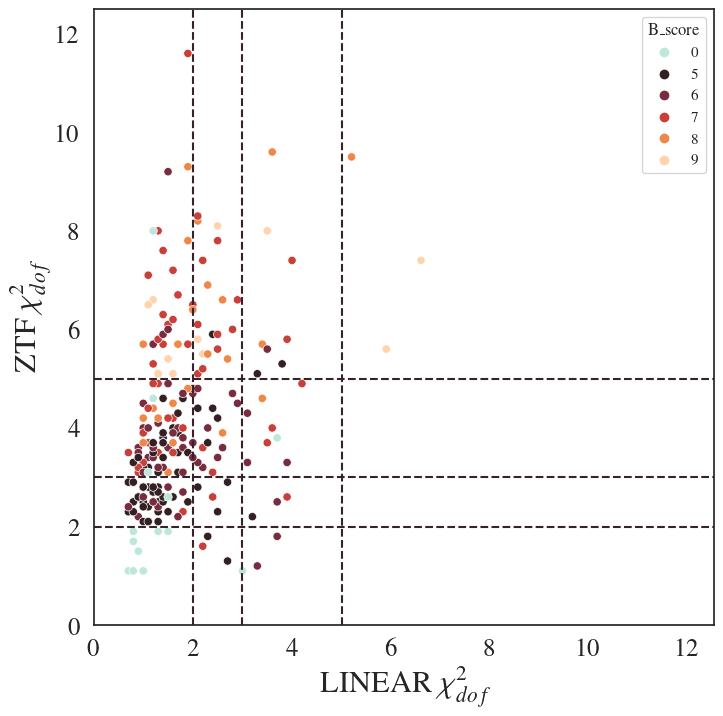

In [17]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(xscale='linear', yscale='linear') 
ax.xaxis.set_tick_params(labelsize=18) 
ax.yaxis.set_tick_params(labelsize=18) 
plt.rc('font', size=24) 


#sns.scatterplot(data=lc_analysis, x='L_chi2dofR', y='Zchi2dofR', marker='x', color=b1)
sns.scatterplot(data=be_MAIN, x='L_chi2r', y='Z_chi2r', marker='o', hue='B_score', palette='icefire')

plt.xlim([0, 12.5]) # limit of 12.5, because above 12.5 there is no point, something is wrong with the data
plt.ylim([0, 12.5])
plt.xlabel(r'LINEAR $\chi_{dof}^2$', fontproperties=font, fontsize=22)
plt.ylabel(r'ZTF $\chi_{dof}^2$', fontproperties=font,fontsize=22)

plt.plot([2.0, 2.0], [0, 12.5], ls='--', c=black1)
plt.plot([3.0, 3.0], [0, 12.5], ls='--', c=black1)
plt.plot([0, 12.5], [2.0, 2.0], ls='--', c=black1)
plt.plot([0, 12.5], [3.0, 3.0], ls='--', c=black1)
plt.plot([5.0, 5.0], [0, 12.5], ls='--', c=black1)
plt.plot([0, 12.5], [5.0, 5.0], ls='--', c=black1)
plt.savefig('../images_paper/final_chi2_b.png', dpi=150)

plt.show()

- algorithm success
- incidence rate

In [18]:
# Algorithm success:

print((len(be_MAIN['LINEAR ID']) / len(b_can['LINEAR ID']))*100,'%')

42.93785310734463 %


In [19]:
# Incidence rate:

print((len(be_MAIN['LINEAR ID']) / rrlyrae.shape[0])*100,'%')

7.752465147908874 %


---

In [20]:
be_MAIN.head()

,LINEAR ID,Plinear,Pztf,N_L,N_Z,L_chi2r,Z_chi2r,L_chi2,Z_chi2,Lampl,Zampl,Ampl_diff,BpeakL,BpeakZ,BperiodL,BperiodZ,LCtype,Periodogram_f,B_score,Blazhko_f
10,158779,0.609207,0.609189,293,616,1.6,3.9,3.7,34.2,0.47,0.68,0.21,1.6443,1.6444,352.7337,350.2627,1,-,7,1
18,263541,0.558218,0.558221,270,503,2.9,6.6,15.8,110.4,0.64,0.82,0.18,1.8621,1.8025,14.1513,89.9685,1,-,7,1
22,393084,0.530027,0.530033,493,372,1.1,3.2,1.6,19.2,0.96,1.31,0.35,1.9447,1.8896,17.2369,347.2222,1,-,6,1
41,810169,0.465185,0.465212,289,743,2.1,2.8,6.0,15.1,0.77,0.75,0.02,2.2232,2.2230,13.6017,13.6082,1,-,5,1
54,924301,0.507503,0.507440,418,189,1.9,9.3,13.8,162.9,0.87,0.79,0.08,2.0043,1.9763,29.5072,178.4121,1,-,8,1


In [21]:
# lc type:
lc_type = be_MAIN['LCtype'].value_counts()
lc_type

1    180
2     48
Name: LCtype, dtype: int64

In [22]:
print('Percentage of RRAB stars is ', (180/(180+48))*100, '%')
print('Percentage of RRC stars is ', (48/(180+48))*100, '%')


Percentage of RRAB stars is  78.94736842105263 %
Percentage of RRC stars is  21.052631578947366 %


In [23]:
print(np.mean(be_MAIN['L_chi2r']))

1.7828947368421053


In [24]:
print(np.mean(be_MAIN['Z_chi2r']))

4.098684210526316


In [25]:
# chi2 area:
chi2area = FINAL_BE_CATALOGUE['ChiType'].value_counts()
chi2area

LZ4    94
LZ5    66
LZ3    54
-      14
Name: ChiType, dtype: int64

In [26]:
print(np.mean(be_MAIN['B_score']))

5.9035087719298245


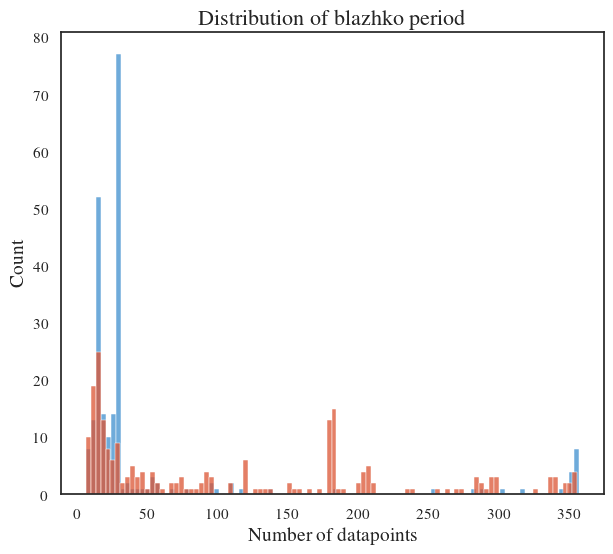

In [27]:
plt.figure(figsize=(7,6))
sns.histplot(data=be_MAIN['BperiodL'].to_numpy(), color=b2, bins=100)
sns.histplot(data=be_MAIN['BperiodZ'].to_numpy(), color=or3, bins=100)
plt.title('Distribution of blazhko period',fontproperties=font,fontsize=16)
plt.xlabel('Number of datapoints', fontproperties=font, fontsize=14)
plt.ylabel('Count', fontproperties=font,fontsize=14)
plt.show()

----

In [28]:
lc_MASTERd = lc_MASTER[(lc_MASTER['N_L'] > 150) & (lc_MASTER['N_Z'] > 150) & (lc_MASTER['Zampl'] < 3) & (lc_MASTER['Lampl'] < 3) & (lc_MASTER['Plinear'] < 4) & (lc_MASTER['Pztf'] < 4)]
lc_MASTERd

,LINEAR ID,Plinear,Pztf,N_L,N_Z,L_chi2r,Z_chi2r,L_chi2,Z_chi2,Lampl,Zampl,Ampl_diff,BpeakL,BpeakZ,BperiodL,BperiodZ,LCtype,Periodogram_f,B_score,Blazhko_f
1,50402,0.643303,0.643294,284,586,0.7,1.1,0.6,1.8,0.48,0.69,0.21,1.6223,1.5918,14.7351,26.8420,1,-,0,-1
2,62892,0.530776,0.530785,276,771,0.9,3.2,1.1,19.8,0.62,0.64,0.02,1.9519,1.9433,14.7319,16.8634,1,-,0,-1
3,91437,0.674733,0.674737,177,564,1.3,2.0,2.8,5.6,0.87,1.21,0.34,1.5498,1.4849,14.7580,355.8719,1,-,0,-1
4,95250,0.313870,0.313876,222,916,0.8,1.4,0.8,3.0,0.48,0.46,0.02,3.2565,3.1889,14.1844,342.4658,2,-,0,-1
7,136668,0.532923,0.532929,310,918,1.1,2.3,1.6,17.0,0.82,0.78,0.04,1.9095,1.9396,30.2847,15.8391,1,-,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845,24231910,0.596312,0.596315,322,294,0.8,1.6,1.0,4.2,0.70,0.95,0.25,1.7110,1.6811,29.4334,242.1308,1,-,0,-1
2846,24236445,0.625308,0.625307,375,243,0.9,1.4,0.9,22.9,0.47,0.74,0.27,1.6357,1.6215,27.3860,44.8029,1,-,0,-1
2853,24257481,0.291239,0.291218,303,397,5.7,7.2,43.1,39.9,0.38,0.42,0.04,3.4701,3.4394,27.4048,180.6685,2,-,7,0
2854,24262387,0.697062,0.348532,338,437,1.2,1.3,2.5,1.9,0.41,0.33,0.08,1.4529,2.9373,54.7495,14.6724,2,-,0,-1


In [29]:
ztf_data = np.load("../outputs/ZTF_dataset_"+end+".npy", allow_pickle=True)

In [30]:
ztf_data[0][1]

,mjd,mag,magerr,catflags,filtercode
0,58234.145590,16.602722,0.014188,0,zg
1,58427.382442,16.502769,0.013724,0,zg
2,58430.365961,16.806061,0.015314,0,zg
3,58438.437373,16.230679,0.012712,0,zg
4,58439.407025,16.335060,0.013060,0,zg
...,...,...,...,...,...
88,58856.199583,16.114397,0.012210,0,zr
89,58859.293299,16.445725,0.013584,0,zr
90,58859.293750,16.512478,0.013936,0,zr
91,58860.268113,16.387852,0.013301,0,zr


In [31]:
period_ALL = lc_MASTERd['Pztf'].to_numpy() # ztf period
ampl_ALL = lc_MASTERd['Zampl'].to_numpy() #just ztf data, not specific for any band
values = np.array(())
mag_ALL = []
for i in lc_MASTERd['LINEAR ID']:
    for j in ztf_data:
        if i == j[0]:
            BandData = j[1].loc[j[1]['filtercode'] == 'zg']
            magZ = BandData['mag'].to_numpy()
            avg = np.mean(magZ)
            if avg > 0:
                mag_ALL.append(avg)


In [32]:
b_can

,LINEAR ID,Plinear,Pztf,N_L,N_Z,L_chi2r,Z_chi2r,L_chi2,Z_chi2,Lampl,Zampl,Ampl_diff,BpeakL,BpeakZ,BperiodL,BperiodZ,LCtype,Periodogram_f,B_score,Blazhko_f
10,158779,0.609207,0.609189,293,616,1.6,3.9,3.7,34.2,0.47,0.68,0.21,1.6443,1.6444,352.7337,350.2627,1,-,7,1
18,263541,0.558218,0.558221,270,503,2.9,6.6,15.8,110.4,0.64,0.82,0.18,1.8621,1.8025,14.1513,89.9685,1,-,7,1
22,393084,0.530027,0.530033,493,372,1.1,3.2,1.6,19.2,0.96,1.31,0.35,1.9447,1.8896,17.2369,347.2222,1,-,6,1
27,514883,0.557723,0.557737,289,555,1.7,5.5,5.3,53.7,0.55,0.72,0.17,1.8472,1.7958,18.4655,357.1429,1,-,8,0
37,737951,0.357023,0.357023,273,871,2.2,6.7,6.0,42.4,0.43,0.34,0.09,2.8038,2.8039,353.3569,332.2259,2,-,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2836,24119124,0.486210,0.486214,243,605,1.2,3.0,1.8,14.6,1.05,1.50,0.45,2.0837,2.0837,37.0096,37.0508,1,-,0,0
2839,24170603,0.526913,0.526916,521,237,1.1,2.4,3.0,11.7,0.93,1.31,0.38,1.9344,1.9503,27.3486,19.0621,1,-,5,0
2840,24185328,0.582147,0.582143,411,700,3.1,1.4,23.8,3.3,0.77,0.65,0.12,1.7517,1.7233,29.5029,182.1494,1,-,5,0
2842,24216004,0.382077,0.381912,546,287,1.9,7.8,6.5,110.6,0.30,0.44,0.14,2.6511,2.6244,29.5596,167.2241,2,-,8,1


In [33]:
period_can = b_can['Pztf'].to_numpy() # ztf period
ampl_can = b_can['Zampl'].to_numpy() #just ztf data, not specific for any band
values = np.array(())
mag_can = []
for i in b_can['LINEAR ID']:
    for j in ztf_data:
        if i == j[0]:
            BandData = j[1].loc[j[1]['filtercode'] == 'zg']
            magZ = BandData['mag'].to_numpy()
            mag_can.append(np.mean(magZ))


In [34]:
be_MAIN

,LINEAR ID,Plinear,Pztf,N_L,N_Z,L_chi2r,Z_chi2r,L_chi2,Z_chi2,Lampl,Zampl,Ampl_diff,BpeakL,BpeakZ,BperiodL,BperiodZ,LCtype,Periodogram_f,B_score,Blazhko_f
10,158779,0.609207,0.609189,293,616,1.6,3.9,3.7,34.2,0.47,0.68,0.21,1.6443,1.6444,352.7337,350.2627,1,-,7,1
18,263541,0.558218,0.558221,270,503,2.9,6.6,15.8,110.4,0.64,0.82,0.18,1.8621,1.8025,14.1513,89.9685,1,-,7,1
22,393084,0.530027,0.530033,493,372,1.1,3.2,1.6,19.2,0.96,1.31,0.35,1.9447,1.8896,17.2369,347.2222,1,-,6,1
41,810169,0.465185,0.465212,289,743,2.1,2.8,6.0,15.1,0.77,0.75,0.02,2.2232,2.2230,13.6017,13.6082,1,-,5,1
54,924301,0.507503,0.507440,418,189,1.9,9.3,13.8,162.9,0.87,0.79,0.08,2.0043,1.9763,29.5072,178.4121,1,-,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2789,23653629,0.442052,0.442055,299,516,2.4,4.4,15.8,47.4,0.82,0.74,0.08,2.3330,2.2839,14.1233,46.0405,1,-,5,1
2804,23846316,0.588263,0.588260,388,202,1.2,2.8,3.0,30.5,0.74,1.12,0.38,1.7339,1.7484,29.4204,20.6271,1,-,5,1
2810,23898397,0.563018,0.562989,323,439,1.6,3.5,7.0,38.5,0.69,0.60,0.09,1.7793,1.8094,318.4713,30.1477,1,-,7,1
2822,24020106,0.542397,0.542396,584,209,2.9,4.5,16.0,54.3,0.52,0.95,0.43,1.8776,1.9232,29.4855,12.5778,1,-,6,1


In [35]:
period_be = be_MAIN['Pztf'].to_numpy() # ztf period
ampl_be = be_MAIN['Zampl'].to_numpy() #just ztf data, not specific for any band
values = np.array(())
mag_be = []
for i in be_MAIN['LINEAR ID']:
    for j in ztf_data:
        if i == j[0]:
            BandData = j[1].loc[j[1]['filtercode'] == 'zg']
            magZ = BandData['mag'].to_numpy()
            mag_be.append(np.mean(magZ))


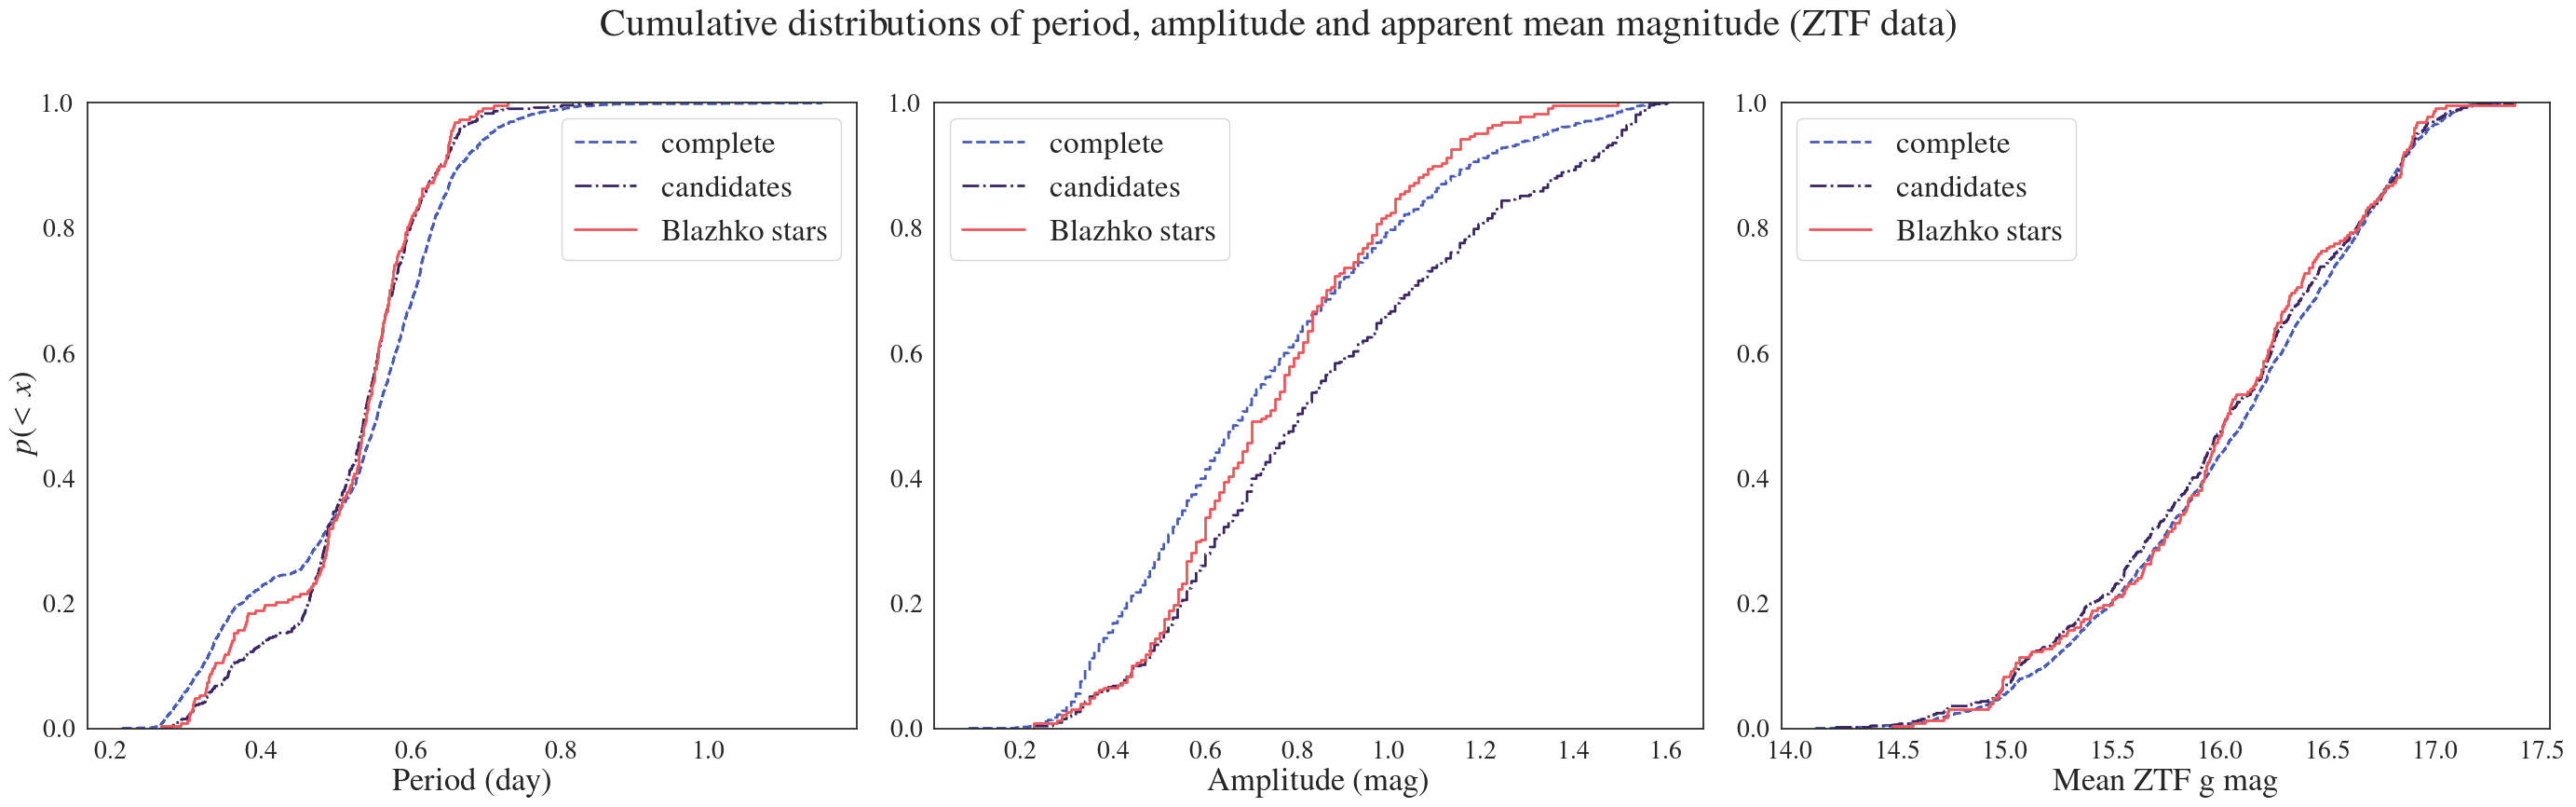

In [36]:
fig, ax = plt.subplots(1,3, figsize=(28,9))   # dimensions of plot
fig.set_facecolor('white') # background color
fig.suptitle('Cumulative distributions of period, amplitude and apparent mean magnitude (ZTF data)', fontproperties=font, fontsize=30)
# PERIOD
# =========
ax[0].ecdf(period_ALL, label="complete",color=b1,lw=2,ls='--')
#n, bins, patches = ax[0].hist(period_ALL, 50, density=True, histtype="step",cumulative=True, label="Cumulative histogram")

ax[0].ecdf(period_can, label="candidates",color=b4,lw=2,ls='-.')
#n, bins, patches = ax[0].hist(period_can, 50, density=True, histtype="step", cumulative=True, label="Cumulative histogram")

ax[0].ecdf(period_be, label="Blazhko stars",color=or4,lw=2)
#n, bins, patches = ax[0].hist(period_be, 50, density=True, histtype="step",cumulative=True, label="Cumulative histogram")
ax[0].set_xlabel('Period (day)', fontproperties=font, fontsize=25)
ax[0].set_ylabel(r'$p( <x )$', fontproperties=font, fontsize=25)
ax[0].tick_params(labelsize=20)
# AMPL
# ======
ax[1].ecdf(ampl_ALL, label="complete",color=b1,lw=2,ls='--')
ax[1].ecdf(ampl_can, label="candidates",color=b4,lw=2,ls='-.')
ax[1].ecdf(ampl_be, label="Blazhko stars",color=or4,lw=2)
ax[1].set_xlabel('Amplitude (mag)', fontproperties=font, fontsize=25)
ax[1].tick_params(labelsize=20)
# AVG MAG
# =======
ax[2].ecdf(mag_ALL, label="complete",color=b1,lw=2,ls='--')
ax[2].ecdf(mag_can, label="candidates",color=b4,lw=2,ls='-.')
ax[2].ecdf(mag_be, label="Blazhko stars",color=or4,lw=2)
ax[2].tick_params(labelsize=20)
ax[2].set_xlabel('Mean ZTF g mag', fontproperties=font, fontsize=25)

ax[0].legend(fontsize=24)
ax[1].legend(fontsize=24)
ax[2].legend(fontsize=24)
fig.tight_layout()
plt.savefig('../images_paper/cumulative_distib.png', dpi=250,bbox_inches = 'tight')
plt.show()

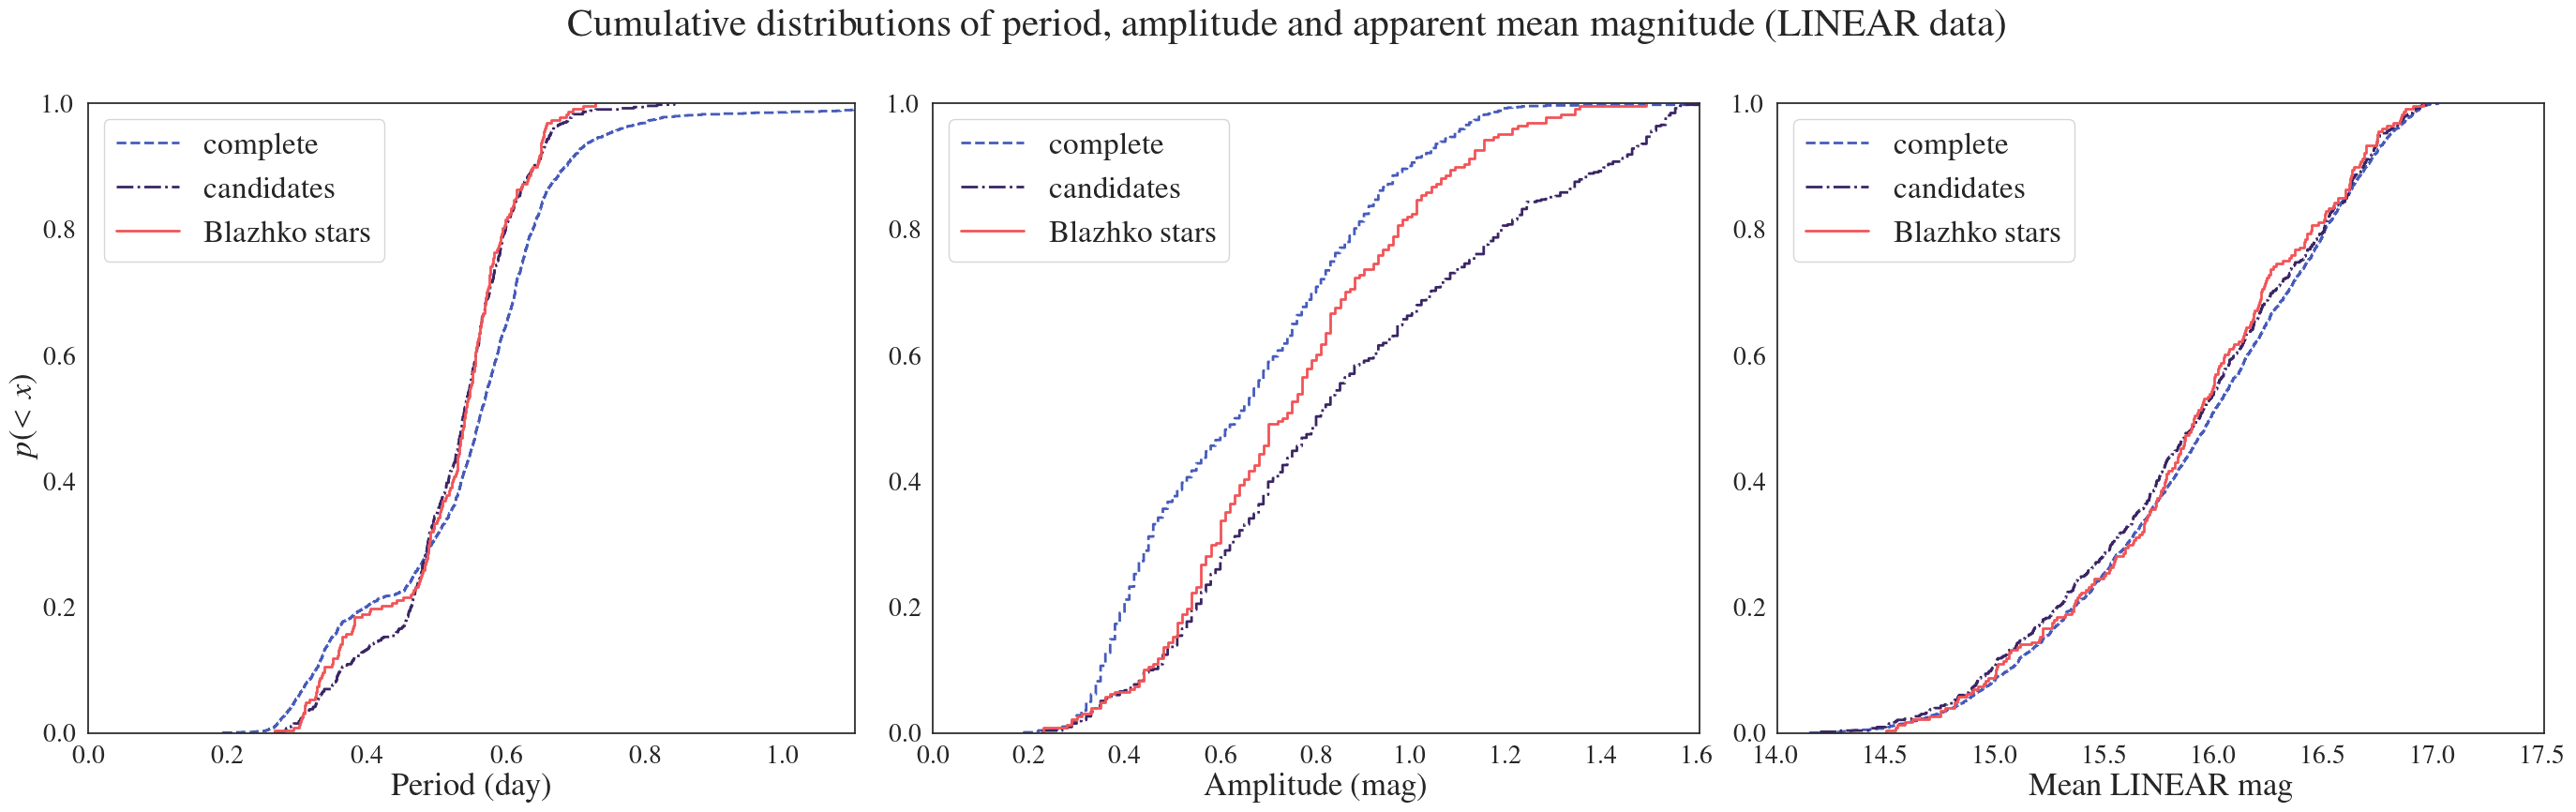

In [37]:
period_ALL = lc_MASTERd['Plinear'].to_numpy() # ztf period
ampl_ALL = lc_MASTERd['Lampl'].to_numpy() #just ztf data, not specific for any band
values = np.array(())
mag_ALL = []
for i in lc_MASTERd['LINEAR ID']:
    mag_ALL.append(np.mean(dataL.get_light_curve(i).T[1]))

period_can = b_can['Plinear'].to_numpy() # ztf period
ampl_can = b_can['Zampl'].to_numpy() #just ztf data, not specific for any band
values = np.array(())
mag_can = []
for i in b_can['LINEAR ID']:
    mag_can.append(np.mean(dataL.get_light_curve(i).T[1]))

period_be = be_MAIN['Plinear'].to_numpy() # ztf period
ampl_be = be_MAIN['Zampl'].to_numpy() #just ztf data, not specific for any band
values = np.array(())
mag_be = []
for i in be_MAIN['LINEAR ID']:
    mag_be.append(np.mean(dataL.get_light_curve(i).T[1]))

fig, ax = plt.subplots(1,3, figsize=(28,9))   # dimensions of plot
fig.set_facecolor('white') # background color
fig.suptitle('Cumulative distributions of period, amplitude and apparent mean magnitude (LINEAR data)', fontproperties=font, fontsize=30)
# PERIOD
# =========
ax[0].ecdf(period_ALL, label="complete",color=b1,lw=2,ls='--')
#n, bins, patches = ax[0].hist(period_ALL, 50, density=True, histtype="step",cumulative=True, label="Cumulative histogram")

ax[0].ecdf(period_can, label="candidates",color=b4,lw=2,ls='-.')
#n, bins, patches = ax[0].hist(period_can, 50, density=True, histtype="step", cumulative=True, label="Cumulative histogram")

ax[0].ecdf(period_be, label="Blazhko stars",color=or4,lw=2)
#n, bins, patches = ax[0].hist(period_be, 50, density=True, histtype="step",cumulative=True, label="Cumulative histogram")
ax[0].set_xlim([0,1.1])
ax[0].set_xlabel('Period (day)', fontproperties=font, fontsize=25)
ax[0].set_ylabel(r'$p( <x )$', fontproperties=font, fontsize=25)
ax[0].tick_params(labelsize=20)
# AMPL
# ======
ax[1].ecdf(ampl_ALL, label="complete",color=b1,lw=2,ls='--')
ax[1].ecdf(ampl_can, label="candidates",color=b4,lw=2,ls='-.')
ax[1].ecdf(ampl_be, label="Blazhko stars",color=or4,lw=2)
ax[1].set_xlim([0,1.6])
ax[1].set_xlabel('Amplitude (mag)', fontproperties=font, fontsize=25)
ax[1].tick_params(labelsize=20)
# AVG MAG
# =======
ax[2].ecdf(mag_ALL, label="complete",color=b1,lw=2,ls='--')
ax[2].ecdf(mag_can, label="candidates",color=b4,lw=2,ls='-.')
ax[2].ecdf(mag_be, label="Blazhko stars",color=or4,lw=2)
ax[2].set_xlim([14.0,17.5])
ax[2].tick_params(labelsize=20)
ax[2].set_xlabel('Mean LINEAR mag', fontproperties=font, fontsize=25)

ax[0].legend(fontsize=24)
ax[1].legend(fontsize=24)
ax[2].legend(fontsize=24)
fig.tight_layout()
plt.savefig('../images_paper/cumulative_distib_L.png', dpi=250,bbox_inches = 'tight')
plt.show()

---

In [38]:
import os
import shutil

In [39]:
be_list = be_MAIN['LINEAR ID'].to_numpy()

source_folder = "../PAPER_support"
destination_folder = "../blazhko_stars"

os.makedirs(destination_folder, exist_ok=True)

files = os.listdir(source_folder)

for file in files:
    source_path = os.path.join(source_folder, file)
    destination_path = os.path.join(destination_folder, file)

    if os.path.isfile(source_path):
        for i in be_list:
            if str(i) in file:
                shutil.move(source_path, destination_path)


In [40]:
source_folder = "../blazhko_stars"

files = os.listdir(source_folder)

# Iterate through files in the folder
for file in files:
    source_path = os.path.join(source_folder, file)  # Full file path

    # Check if it's a file and matches the desired pattern
    if os.path.isfile(source_path):
        for i in be_list:
            # Check for specific substring patterns in the filename
            if 'LCplot_' in file and str(i) in file:
                # Define new name and full destination path
                new_name = f"{i}_ph.png"
                new_path = os.path.join(source_folder, new_name)
                
                # Rename the file
                os.rename(source_path, new_path)

In [41]:
source_folder = "../blazhko_stars"

files = os.listdir(source_folder)

# Iterate through files in the folder
for file in files:
    source_path = os.path.join(source_folder, file)  # Full file path

    # Check if it's a file and matches the desired pattern
    if os.path.isfile(source_path):
        for i in be_list:
            # Check for specific substring patterns in the filename
            if 'LCplotBySeason' in file and str(i) in file:
                # Define new name and full destination path
                new_name = f"{i}_sn.png"
                new_path = os.path.join(source_folder, new_name)
                
                # Rename the file
                os.rename(source_path, new_path)
            elif 'periodogram' in file and str(i) in file:
                # Define new name and full destination path
                new_name = f"{i}_p.png"
                new_path = os.path.join(source_folder, new_name)
                
                # Rename the file
                os.rename(source_path, new_path)
            elif 'season_plot' in file and str(i) in file:
                # Define new name and full destination path
                new_name = f"{i}_sp.png"
                new_path = os.path.join(source_folder, new_name)
                
                # Rename the file
                os.rename(source_path, new_path)

In [42]:
effect_present = ['B','B','L','L','L','L','B',
    'L','B','L','L','B','L','L','B','Z','Z','L',
    'B','L','L','B','Z','L','Z','L','B','Z','B',
    'B','L','L','B','Z','B','L','B','L','L','B','L',
    'L','L','Z','B','B','B','Z','Z','B','Z','B',
    'L','L','Z','Z','Z','B','B','Z','B','B','Z',
    'B','B','Z','B','B','B','L','B','Z','B','B',
    'B','L','L','B','B','B','Z','B','L','L','L',
    'B','L','B','B','L','L','B','L','B','B','B',
    'L','L','B','Z','Z','Z','B','Z','L','B','B',
    'B','B','B','B','L','Z','B','B','Z','B','L',
    'L','Z','Z','B','B','B','Z','Z','B','L','B',
    'L','Z','L','B','Z','Z','Z','Z','Z','Z','Z',
    'Z','B','Z','Z','Z','Z','L','B','B','B','Z',
    'B','B','B','Z','B','Z','Z','Z','Z','B','B',
    'Z','B','Z','Z','L','B','B','L','B','B','Z',
    'Z','B','Z','Z','B','B','L','B','Z','B','Z',
    'Z','Z','Z','Z','B','Z','Z','L','B','L','B',
    'Z','Z','B','Z','B','Z','L','B','B','B','B',
    'B','B','L','L','B','B','B','L','B','L','B',
    'B','B','L','B','B','L','B','L','Z','L','B'
]

In [43]:
len(effect_present)

228

# Updated table to include effect presence

In [44]:
be_MAIN['Presence'] = effect_present
be_MAIN.head()

,LINEAR ID,Plinear,Pztf,N_L,N_Z,L_chi2r,Z_chi2r,L_chi2,Z_chi2,Lampl,...,Ampl_diff,BpeakL,BpeakZ,BperiodL,BperiodZ,LCtype,Periodogram_f,B_score,Blazhko_f,Presence
10,158779,0.609207,0.609189,293,616,1.6,3.9,3.7,34.2,0.47,...,0.21,1.6443,1.6444,352.7337,350.2627,1,-,7,1,B
18,263541,0.558218,0.558221,270,503,2.9,6.6,15.8,110.4,0.64,...,0.18,1.8621,1.8025,14.1513,89.9685,1,-,7,1,B
22,393084,0.530027,0.530033,493,372,1.1,3.2,1.6,19.2,0.96,...,0.35,1.9447,1.8896,17.2369,347.2222,1,-,6,1,L
41,810169,0.465185,0.465212,289,743,2.1,2.8,6.0,15.1,0.77,...,0.02,2.2232,2.2230,13.6017,13.6082,1,-,5,1,L
54,924301,0.507503,0.507440,418,189,1.9,9.3,13.8,162.9,0.87,...,0.08,2.0043,1.9763,29.5072,178.4121,1,-,8,1,L


In [45]:
be_MAIN.to_csv('../outputs/be_MAIN_presence.csv', index=False)

In [46]:
pL = pd.read_csv('../outputs/groupL_p.csv')
pZ= pd.read_csv('../outputs/groupZ_p.csv')

In [47]:
b = pL['LINEAR id'].to_numpy()
a = pZ['LINEAR id'].to_numpy()

source_folder = "../blazhko_stars"
destination_folder = "../periodogram"

os.makedirs(destination_folder, exist_ok=True)

files = os.listdir(source_folder)

for file in files:
    source_path = os.path.join(source_folder, file)
    destination_path = os.path.join(destination_folder, file)

    if os.path.isfile(source_path):
        for i in b:
            if str(i) in file:
                shutil.move(source_path, destination_path)
        for j in a:
            if str(j) in file:
                shutil.move(source_path, destination_path)


In [48]:
L_stars = be_MAIN[(be_MAIN['Presence'] == 'L')]
B_stars = be_MAIN[(be_MAIN['Presence'] == 'B')]
Z_stars = be_MAIN[(be_MAIN['Presence'] == 'Z')]

In [49]:
l = L_stars['LINEAR ID'].to_numpy()
b = B_stars['LINEAR ID'].to_numpy()
z = Z_stars['LINEAR ID'].to_numpy()

source_folder = "../blazhko_stars"

folder1 = "../blazhko_stars/L stars"
folder2 = "../blazhko_stars/Both stars"
folder3 = "../blazhko_stars/Z stars"

os.makedirs(folder1, exist_ok=True)
os.makedirs(folder2, exist_ok=True)
os.makedirs(folder3, exist_ok=True)

files = os.listdir(source_folder)

for file in files:
    source_path = os.path.join(source_folder, file)
    folder1_path = os.path.join(folder1, file)
    folder2_path = os.path.join(folder2, file)
    folder3_path = os.path.join(folder3, file)

    if os.path.isfile(source_path):
        for i in l:
            if str(i) in file:
                shutil.move(source_path, folder1_path)
        for j in b:
            if str(j) in file:
                shutil.move(source_path, folder2_path)
        for k in z:
            if str(k) in file:
                shutil.move(source_path, folder3_path)


---

## Tablica iz appendixa

In [50]:
be_MAIN.head(50)

,LINEAR ID,Plinear,Pztf,N_L,N_Z,L_chi2r,Z_chi2r,L_chi2,Z_chi2,Lampl,...,Ampl_diff,BpeakL,BpeakZ,BperiodL,BperiodZ,LCtype,Periodogram_f,B_score,Blazhko_f,Presence
10,158779,0.609207,0.609189,293,616,1.6,3.9,3.7,34.2,0.47,...,0.21,1.6443,1.6444,352.7337,350.2627,1,-,7,1,B
18,263541,0.558218,0.558221,270,503,2.9,6.6,15.8,110.4,0.64,...,0.18,1.8621,1.8025,14.1513,89.9685,1,-,7,1,B
22,393084,0.530027,0.530033,493,372,1.1,3.2,1.6,19.2,0.96,...,0.35,1.9447,1.8896,17.2369,347.2222,1,-,6,1,L
41,810169,0.465185,0.465212,289,743,2.1,2.8,6.0,15.1,0.77,...,0.02,2.2232,2.2230,13.6017,13.6082,1,-,5,1,L
54,924301,0.507503,0.507440,418,189,1.9,9.3,13.8,162.9,0.87,...,0.08,2.0043,1.9763,29.5072,178.4121,1,-,8,1,L
59,970326,0.592233,0.592231,275,552,1.1,2.1,1.9,7.7,0.51,...,0.24,1.7563,1.6992,14.7656,93.2836,1,-,5,1,L
64,999528,0.658401,0.658407,564,213,1.2,2.7,1.8,21.7,0.57,...,0.35,1.5527,1.5510,29.5247,31.0366,1,-,5,1,B
66,1005497,0.653607,0.653605,607,192,1.1,2.1,2.1,12.4,0.60,...,0.23,1.5639,1.5481,29.4638,55.1116,1,-,5,1,L
76,1092244,0.649496,0.649558,590,326,1.2,3.6,2.3,32.1,0.72,...,0.14,1.5735,1.5640,29.5421,40.8330,1,-,7,1,B
93,1240665,0.632528,0.632522,468,311,3.0,1.1,25.2,1.6,0.33,...,0.00,1.6149,1.5865,29.4942,182.3154,1,Z,0,2,L


---

In [51]:
be_can = pd.read_csv('../outputs/blazhko_canmodfinal.csv')

In [52]:
lc_analysis[(lc_analysis['L_chi2dofR'] > 5.0) & (lc_analysis['Zchi2dofR'] > 5.0) & (lc_analysis['NdataLINEAR'] > 150) & (lc_analysis['NdataZTF'] > 150)]

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,LCtype
262,2683009,0.606278,0.606210,0.606244,0.999888,180,63.6,6.6,69.4,5.7,...,1.6603,93.7207,0.0028,17.0820,0.30,0.00011,NaN,NaN,NaN,1
654,6246025,0.499343,0.518974,0.509159,1.039314,225,50.9,5.9,51.7,6.8,...,1.9297,355.2398,0.0147,20.7838,190.77,0.03856,NaN,NaN,NaN,1
978,8952153,0.499327,1.042600,0.770964,2.088010,239,113.3,9.0,85.8,9.2,...,1.0026,22.9938,0.0451,14.3194,121.91,0.70467,NaN,NaN,NaN,1
1313,11321453,0.499245,0.512783,0.506014,1.027117,210,105.3,9.8,93.7,9.5,...,1.9764,38.0156,0.0334,25.9549,15.38,0.02675,NaN,NaN,NaN,1
1465,12383709,0.498630,0.492823,0.495726,0.988354,201,99.0,8.3,73.5,8.0,...,2.0423,75.7863,0.0044,16.4530,190.87,0.01171,NaN,NaN,NaN,1
1611,13585738,0.475070,0.475040,0.475055,0.999937,224,121.4,5.9,195.4,8.6,...,2.1563,19.5408,0.0023,19.1771,0.22,0.00006,NaN,NaN,NaN,1
1687,14193913,0.565065,0.565083,0.565074,1.000032,224,54.9,5.2,59.0,5.4,...,1.8046,28.6123,0.0018,8.8352,0.24,0.00003,NaN,NaN,NaN,1
1966,16379790,0.346321,0.585757,0.466039,1.691370,200,66.1,7.5,114.7,9.9,...,1.7210,72.2543,0.0052,8.1377,0.04,0.51377,NaN,NaN,NaN,1
2421,20056718,0.997155,0.484108,0.740632,0.485489,209,33.8,6.8,28.2,5.3,...,2.0971,31.7965,0.0174,34.3996,3534.29,0.69272,NaN,NaN,NaN,1
2853,24257481,0.291239,0.291218,0.291228,0.999928,303,43.1,5.7,67.1,7.8,...,3.4394,180.6685,0.0066,12.1123,0.04,0.00007,NaN,NaN,NaN,2


In [53]:
be_can[(be_can['L_chi2dofR'] > 5.0) & (be_can['Zchi2dofR'] > 5.0)]

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,MainPeakZ,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score
55,2683009,0.606278,0.606210,0.606244,0.999888,180,63.6,6.6,69.4,5.7,...,1.6496,1.6603,93.7207,0.0028,17.0820,0.30,0.00011,-,LZ5,9
299,13585738,0.475070,0.475040,0.475055,0.999937,224,121.4,5.9,195.4,8.6,...,2.1051,2.1563,19.5408,0.0023,19.1771,0.22,0.00006,-,LZ5,9
310,14193913,0.565065,0.565083,0.565074,1.000032,224,54.9,5.2,59.0,5.4,...,1.7697,1.8046,28.6123,0.0018,8.8352,0.24,0.00003,-,LZ5,8
530,24257481,0.291239,0.291218,0.291228,0.999928,303,43.1,5.7,67.1,7.8,...,3.4339,3.4394,180.6685,0.0066,12.1123,0.04,0.00007,-,LZ5,7


## Contour plot

In [54]:
# configuring fonts for plotting
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = r'\usepackage{txfonts}'  # Use TX Times font

# Set up your font properties (optional)
font = FontProperties()
font.set_family('serif')
font.set_name('Times')  # Times font


In [55]:
from scipy.stats import gaussian_kde

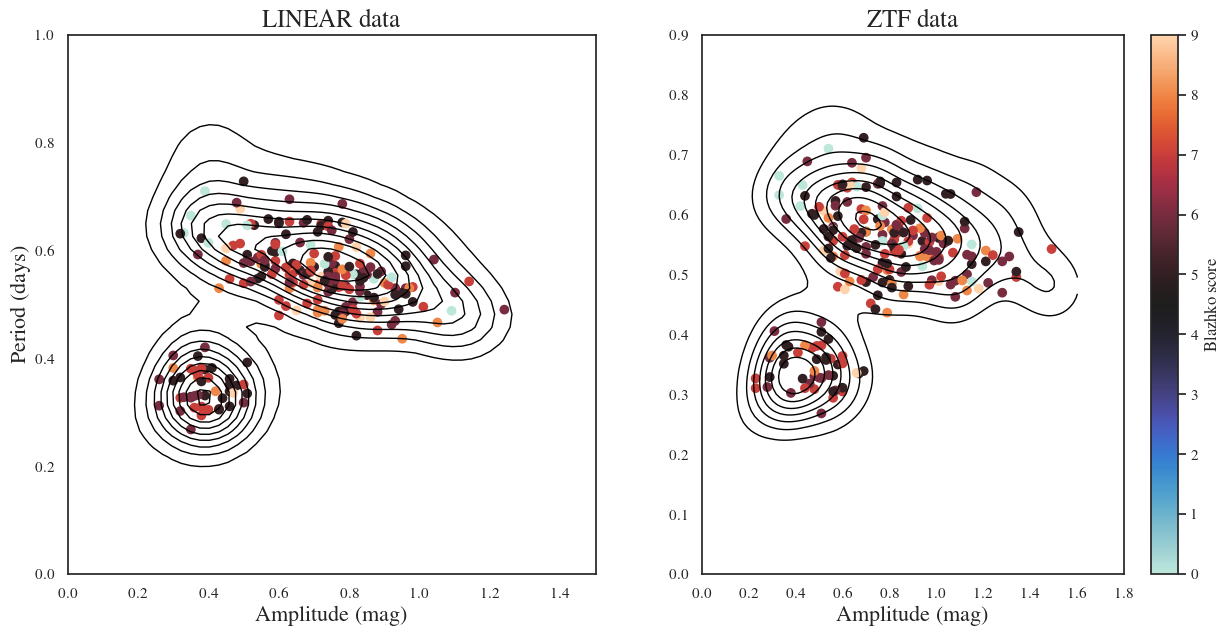

In [56]:
fig, ax = plt.subplots(1,2, figsize=(15,7))   # dimensions of plot
fig.set_facecolor('white') # background color

amp_allL = lc_MASTERd['Lampl'].to_numpy()
amp_allZ = lc_MASTERd['Zampl'].to_numpy()
amp_bL = be_MAIN['Lampl'].to_numpy()
amp_bZ = be_MAIN['Zampl'].to_numpy()


period_allL = lc_MASTERd['Plinear'].to_numpy()
period_allZ = lc_MASTERd['Pztf'].to_numpy()
period_bL = be_MAIN['Plinear'].to_numpy()
period_bZ = be_MAIN['Pztf'].to_numpy()

blazhko_score = be_MAIN['B_score'].to_numpy()

# --------

xy = np.vstack([amp_allL, period_allL])
density = gaussian_kde(xy)(xy)

x = np.linspace(min(amp_allL), max(amp_allL), 100)
y = np.linspace(min(period_allL), max(period_allL), 100)
X, Y = np.meshgrid(x, y)

Z = gaussian_kde(xy)(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

num_levels = 12  
levels = np.linspace(Z.min(), Z.max(), num_levels)

ax[0].contour(X, Y, Z, levels=levels, colors="black", linewidths=1)  
scatter = ax[0].scatter(amp_bL, period_bL, c=blazhko_score, cmap="icefire")

ax[0].set_xlim([0,1.5])
ax[0].set_ylim([0,1.0])
ax[0].set_title('LINEAR data', fontproperties=font, fontsize=18)
ax[0].set_ylabel('Period (days)',fontproperties=font, fontsize=16)
# ===================

xy2 = np.vstack([amp_allZ, period_allZ])
density = gaussian_kde(xy2)(xy2)

x2 = np.linspace(min(amp_allZ), max(amp_allZ), 100)
y2 = np.linspace(min(period_allZ), max(period_allZ), 100)
X2, Y2 = np.meshgrid(x2, y2)

Z2 = gaussian_kde(xy2)(np.vstack([X2.ravel(), Y2.ravel()])).reshape(X2.shape)

levels2 = np.linspace(Z2.min(), Z2.max(), num_levels)

ax[1].contour(X2, Y2, Z2, levels=levels, colors="black", linewidths=1) 
scatter2 = ax[1].scatter(amp_bZ, period_bZ, c=blazhko_score, cmap="icefire")

ax[1].set_xlim([0,1.8])
ax[1].set_ylim([0,0.9])
ax[1].set_title('ZTF data', fontproperties=font, fontsize=18)
ax[1].set_xlabel('Amplitude (mag)',fontproperties=font, fontsize=16)
ax[0].set_xlabel('Amplitude (mag)',fontproperties=font, fontsize=16)
plt.colorbar(scatter2, label="Blazhko score")
plt.savefig('../images_paper/contour_plot_amp_period.png', dpi=200, bbox_inches = 'tight')
plt.show()

In [57]:
Pall = period_allZ[(period_allZ<0.45)&(amp_allZ<0.7)]
PB = period_bZ[(period_bZ<0.45)&(amp_bZ<0.7)]
print(np.median(Pall), np.median(PB), np.median(PB)/np.median(Pall), np.median(PB)-np.median(Pall))
print(np.std(PB), len(PB), np.std(PB)/np.sqrt(len(PB)))

0.3333335 0.3388135 1.016439991780004 0.005479999999999985
0.032904291300830724 46 0.004851473075285047


In [58]:
Pall = period_allZ[period_allZ>0.45]
PB = period_bZ[period_bZ>0.45]
print(np.median(Pall), np.median(PB), np.median(PB)/np.median(Pall), np.median(PB)-np.median(Pall))
print(np.std(PB), len(PB), np.std(PB)/np.sqrt(len(PB)))

0.586458 0.556391 0.9487311964369144 -0.030067000000000066
0.056544510590366276 180 0.0042145789811505255


In [59]:
Pall = period_allL[amp_allZ>(2.4-4*period_allZ)]
PB = period_bL[amp_bZ>(2.4-4*period_bZ)]
print(np.median(Pall), np.median(PB), np.median(PB)/np.median(Pall), np.median(PB)-np.median(Pall))
print(np.std(PB), len(PB), np.std(PB)/np.sqrt(len(PB)))
# print(-0.03015/0.00427578)   # ab
#print(0.0051/0.00485)     # c 
print(-0.02705/0.00427581)

0.583117 0.5560655 0.9536087954904419 -0.027051500000000006
0.057683895058684424 182 0.00427581477946005
-6.326286715265646


In [60]:
print(0.0054799/0.004851473)
print(-0.030067000/0.00421457)

1.1295332366066966
-7.134061126046074


In [61]:
Pall = amp_allZ[period_allZ>0.45]
PB = amp_bZ[period_bZ>0.45]
print(np.median(Pall), np.median(PB), np.median(PB)/np.median(Pall), np.median(PB)-np.median(Pall))
print(np.std(PB), len(PB), np.std(PB)/np.sqrt(len(PB)))
print(0.010000/0.01695470)

0.8 0.81 1.0125 0.010000000000000009
0.2274711757618295 180 0.016954700397508442
0.5898069561832413


In [62]:
Pall = amp_allL[amp_allZ<(2.4-4*period_allZ)]
PB = amp_bL[amp_bZ<(2.4-4*period_bZ)]
print(np.median(Pall), np.median(PB), np.median(PB)/np.median(Pall), np.median(PB)-np.median(Pall))
print(np.std(PB), len(PB), np.std(PB)/np.sqrt(len(PB)))
# print(0.005000/0.01677)  # ab
print(0.085000/0.0169)    # c 

0.38 0.38 1.0 0.0
0.0628768412411219 46 0.009270684469431923
5.029585798816569


In [63]:
Xlc_MASTERd = lc_MASTERd[lc_MASTERd['LCtype']==1]
Xbe_MAIN = be_MAIN[be_MAIN['LCtype']==1]
print(len(Xlc_MASTERd), len(Xbe_MAIN), len(Xbe_MAIN)/len(Xlc_MASTERd))

1474 180 0.12211668928086838


In [64]:
ab = Xlc_MASTERd[Xlc_MASTERd['Zampl']>(2.4-4*Xlc_MASTERd['Pztf'])]
print(len(ab))

1469


In [65]:
Xlc_MASTERd = lc_MASTERd[lc_MASTERd['LCtype']==2]
Xbe_MAIN = be_MAIN[be_MAIN['LCtype']==2]
print(len(Xlc_MASTERd), len(Xbe_MAIN), len(Xbe_MAIN)/len(Xlc_MASTERd))

522 48 0.09195402298850575


In [66]:
c = Xlc_MASTERd[Xlc_MASTERd['Zampl']<(2.4-4*Xlc_MASTERd['Pztf'])]
print(len(c))

493


In [67]:
print(np.sqrt(180)/1474)

0.00910204061397472


In [68]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.8.0


In [1]:
fig, ax = plt.subplots(1,2, figsize=(15,7))   # dimensions of plot
fig.set_facecolor('white') # background color

amp_allL = lc_MASTERd['Lampl'].to_numpy()
amp_allZ = lc_MASTERd['Zampl'].to_numpy()
amp_bL = be_MAIN['Lampl'].to_numpy()
amp_bZ = be_MAIN['Zampl'].to_numpy()


period_allL = lc_MASTERd['Plinear'].to_numpy()
period_allZ = lc_MASTERd['Pztf'].to_numpy()
period_bL = be_MAIN['Plinear'].to_numpy()
period_bZ = be_MAIN['Pztf'].to_numpy()

blazhko_score = be_MAIN['B_score'].to_numpy()

# --------

xy = np.vstack([amp_allL, period_allL])
density = gaussian_kde(xy)(xy)

x = np.linspace(min(amp_allL), max(amp_allL), 100)
y = np.linspace(min(period_allL), max(period_allL), 100)
X, Y = np.meshgrid(x, y)

Z = gaussian_kde(xy)(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

num_levels = 12  
levels = np.linspace(Z.min(), Z.max(), num_levels)

#ax[0].contour(X, Y, Z, levels=levels, colors="black", linewidths=1)  
#scatter = ax[0].scatter(amp_bL, period_bL, c=blazhko_score, cmap="coolwarm")
ax[0].contour(Y, X, Z, levels=levels, colors="black", linewidths=1)  
scatter = ax[0].scatter(period_bL, amp_bL, c=blazhko_score, cmap="coolwarm")


ax[0].set_xlim([0.2,0.85])
ax[0].set_ylim([0,1.6])

ax[0].set_title('LINEAR data', fontproperties=font, fontsize=18)
ax[0].set_xlabel('Period (days)',fontproperties=font, fontsize=22)
ax[0].set_ylabel('Amplitude (mag)',fontproperties=font, fontsize=22)
# ===================

xy2 = np.vstack([amp_allZ, period_allZ])
density = gaussian_kde(xy2)(xy2)

x2 = np.linspace(min(amp_allZ), max(amp_allZ), 100)
y2 = np.linspace(min(period_allZ), max(period_allZ), 100)
X2, Y2 = np.meshgrid(x2, y2)

Z2 = gaussian_kde(xy2)(np.vstack([X2.ravel(), Y2.ravel()])).reshape(X2.shape)

levels2 = np.linspace(Z2.min(), Z2.max(), num_levels)

#ax[1].contour(X2, Y2, Z2, levels=levels, colors="black", linewidths=1) 
#scatter2 = ax[1].scatter(amp_bZ, period_bZ, c=blazhko_score, cmap="coolwarm")
ax[1].contour(Y2, X2, Z2, levels=levels, colors="black", linewidths=1) 
scatter2 = ax[1].scatter(period_bZ, amp_bZ, c=blazhko_score, cmap="coolwarm")

ax[1].set_xlim([0.2,0.85])
ax[1].set_ylim([0,1.6])

ax[1].set_title('ZTF data', fontproperties=font, fontsize=18)
ax[1].set_xlabel('Period (days)',fontproperties=font, fontsize=22)
ax[1].set_ylabel('Amplitude (mag)',fontproperties=font, fontsize=22)
plt.colorbar(scatter2, label="Blazhko score")
plt.savefig('../images_paper/contour_plot_amp_periodZI.png', dpi=300, bbox_inches = 'tight')
plt.show()

NameError: name 'plt' is not defined

In [70]:
len(period_bL)

228

## Compactify Ema's code

In [97]:
def plotCDFs(pALL, pCan, pBlazh, aALL, aCan, aBlazh, mALL, mCan, mBlazh, title=""): 
    
    if title=="": 
        title = 'Cumulative distributions of period, amplitude and apparent mean magnitude (ZTF data)'
    fig, ax = plt.subplots(1,3, figsize=(28,9))   # dimensions of plot
    fig.set_facecolor('white') # background color
    fig.suptitle(title, fontproperties=font, fontsize=30)

    # PERIOD
    ax[0].ecdf(pALL, label="complete",color=b1,lw=2,ls='--')
    ax[0].ecdf(pCan, label="candidates",color=b4,lw=2,ls='-.')
    ax[0].ecdf(pBlazh, label="Blazhko stars",color=or4,lw=2)
    ax[0].set_xlabel('Period (day)', fontproperties=font, fontsize=25)
    ax[0].set_ylabel(r'$p( <x )$', fontproperties=font, fontsize=25)
    ax[0].tick_params(labelsize=20)

    # AMPL 
    ax[1].ecdf(aALL, label="complete",color=b1,lw=2,ls='--')
    ax[1].ecdf(aCan, label="candidates",color=b4,lw=2,ls='-.')
    ax[1].ecdf(aBlazh, label="Blazhko stars",color=or4,lw=2)
    ax[1].set_xlabel('Amplitude (mag)', fontproperties=font, fontsize=25)
    ax[1].tick_params(labelsize=20)

    # AVG MAG
    ax[2].ecdf(mALL, label="complete",color=b1,lw=2,ls='--')
    ax[2].ecdf(mCan, label="candidates",color=b4,lw=2,ls='-.')
    ax[2].ecdf(mBlazh, label="Blazhko stars",color=or4,lw=2)
    ax[2].tick_params(labelsize=20)
    ax[2].set_xlabel('Mean ZTF g mag', fontproperties=font, fontsize=25)

    ax[0].legend(fontsize=24)
    ax[1].legend(fontsize=24)
    ax[2].legend(fontsize=24)
    fig.tight_layout()
    plt.savefig('../images_paper/cumulative_distrib.png', dpi=250,bbox_inches = 'tight')
    plt.show()

In [88]:
def getCDFinputsZTF(dfAll, ztf_data,  RRLyrType=-1):
    if RRLyrType > -1: 
        df = dfAll[dfAll['LCtype']==RRLyrType]
    else:
        df = dfAll
    period = df['Pztf'].to_numpy() # ztf period
    ampl = df['Zampl'].to_numpy() #just ztf data, not specific for any band
    values = np.array(())
    mag = []
    for i in df['LINEAR ID']:
        for j in ztf_data:
            if i == j[0]:
                BandData = j[1].loc[j[1]['filtercode'] == 'zg']
                magZ = BandData['mag'].to_numpy()
                avg = np.mean(magZ)
                if avg > 0:
                    mag.append(avg)   
    return period, ampl, mag 

In [89]:
RRLyrType = 'all'

In [90]:
pAll, aAll, mAll = getCDFinputsZTF(lc_MASTERd, ztf_data)

In [91]:
pCan, aCan, mCan = getCDFinputsZTF(b_can, ztf_data)

In [92]:
pBlazh, aBlazh, mBlazh = getCDFinputsZTF(be_MAIN, ztf_data)

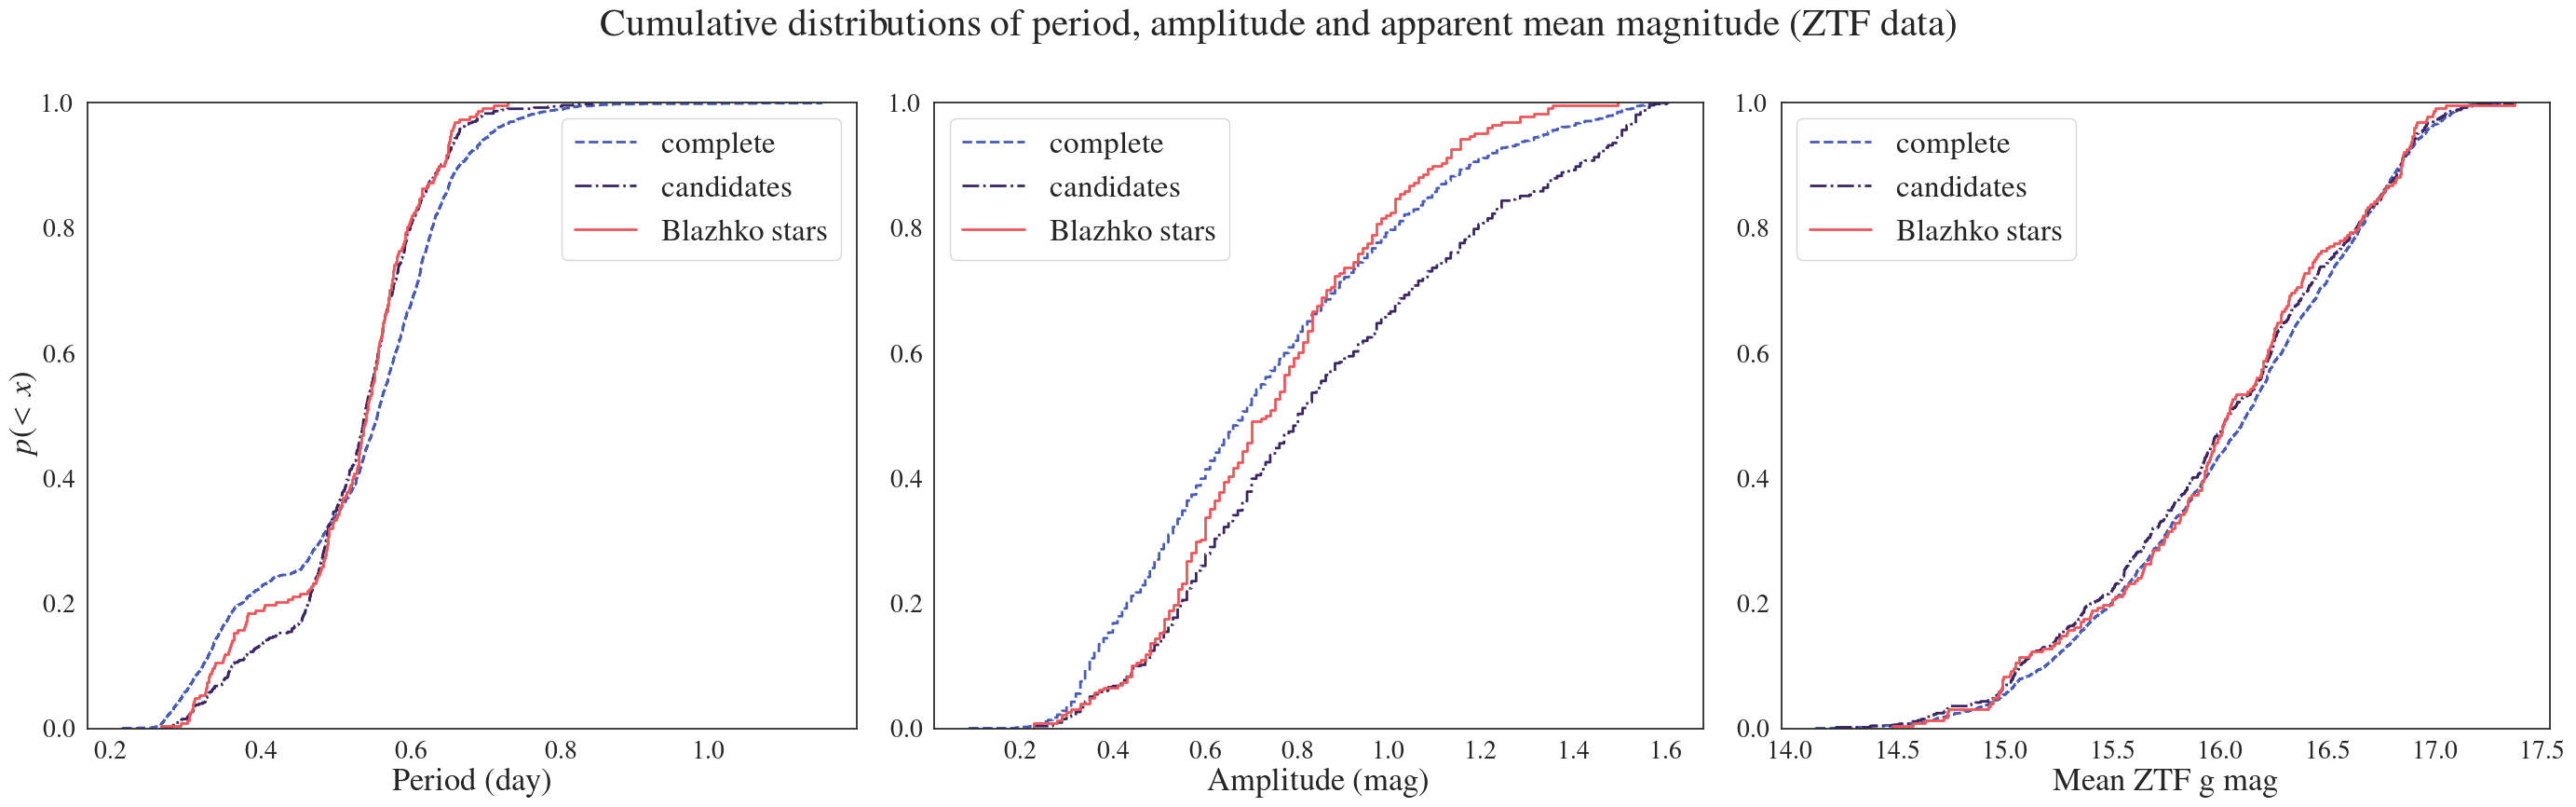

In [93]:
plotCDFs(pAll, pCan, pBlazh, aAll, aCan, aBlazh, mAll, mCan, mBlazh)

In [103]:
RRLyrType = 1
title = 'ab type RR Lyrae (ZTF data)'
pAll, aAll, mAll = getCDFinputsZTF(lc_MASTERd, ztf_data, RRLyrType)
pCan, aCan, mCan = getCDFinputsZTF(b_can, ztf_data, RRLyrType)
pBlazh, aBlazh, mBlazh = getCDFinputsZTF(be_MAIN, ztf_data, RRLyrType)

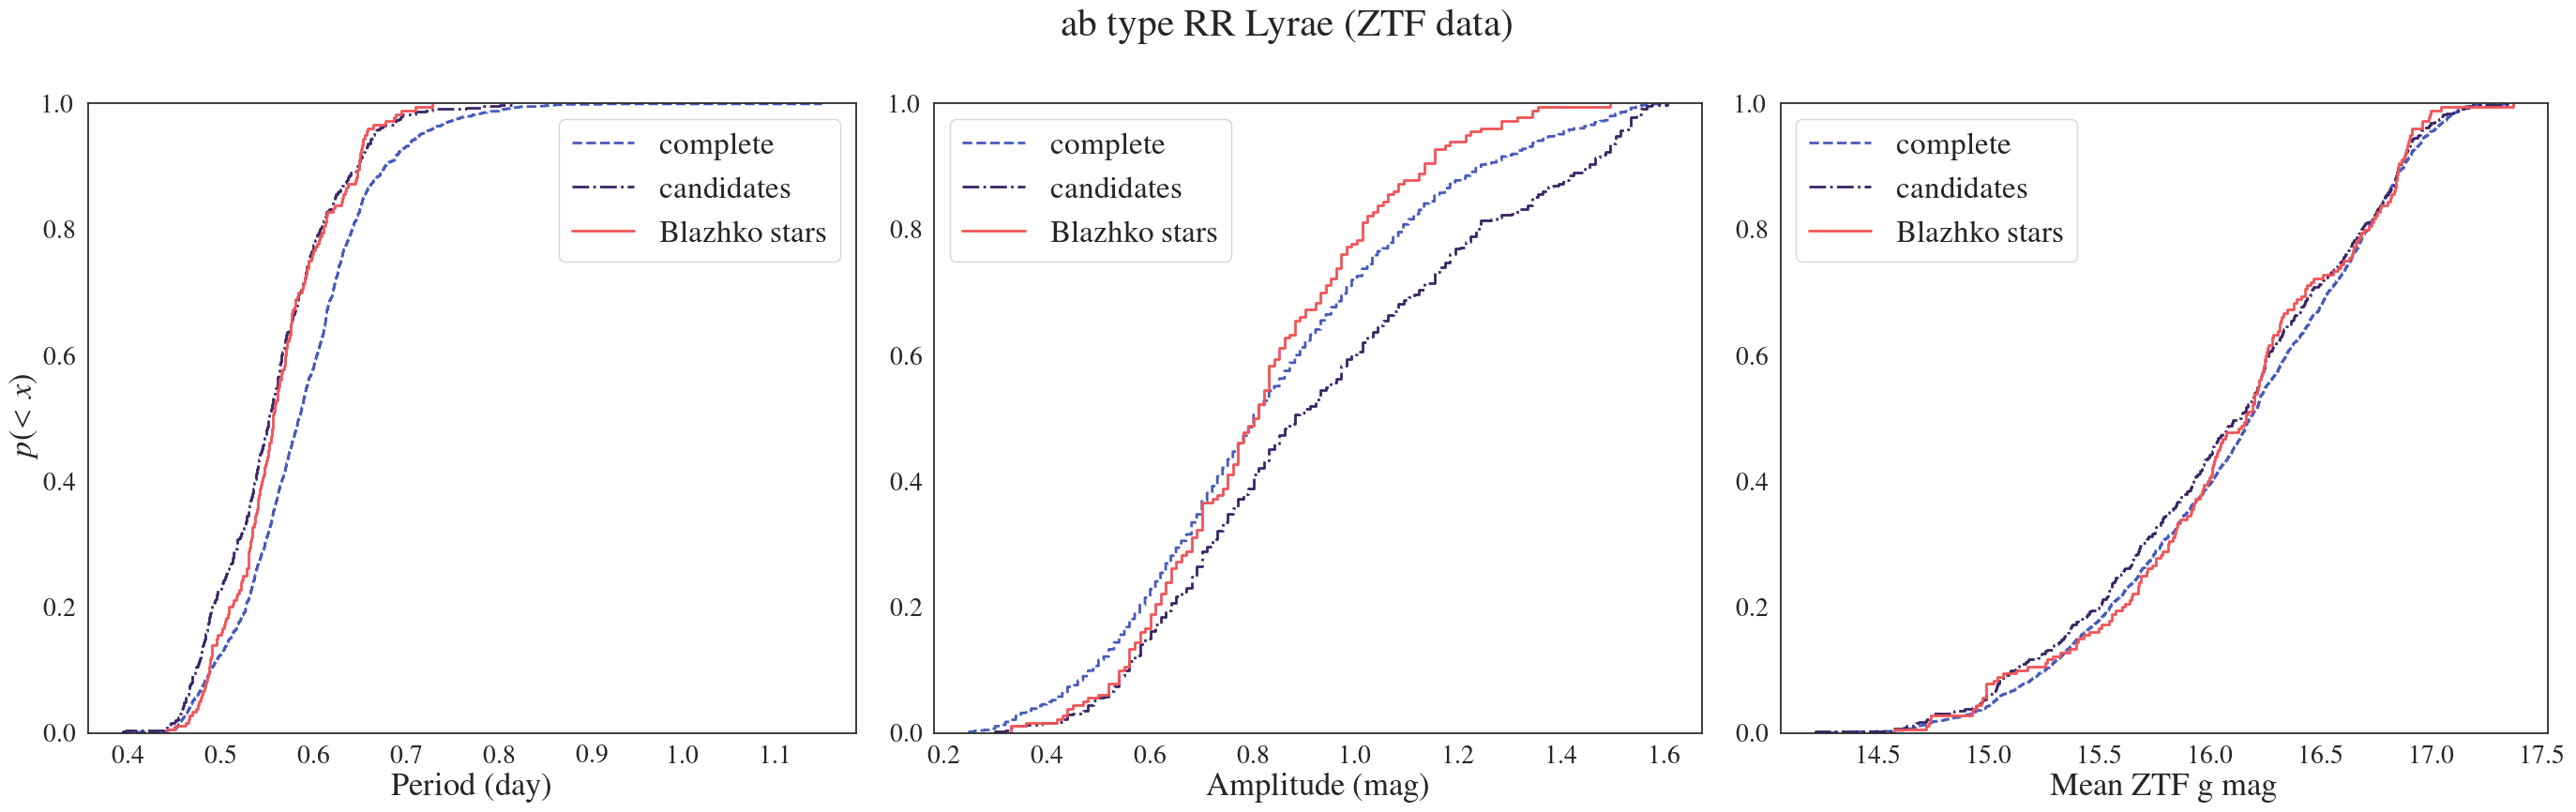

In [104]:
plotCDFs(pAll, pCan, pBlazh, aAll, aCan, aBlazh, mAll, mCan, mBlazh, title)

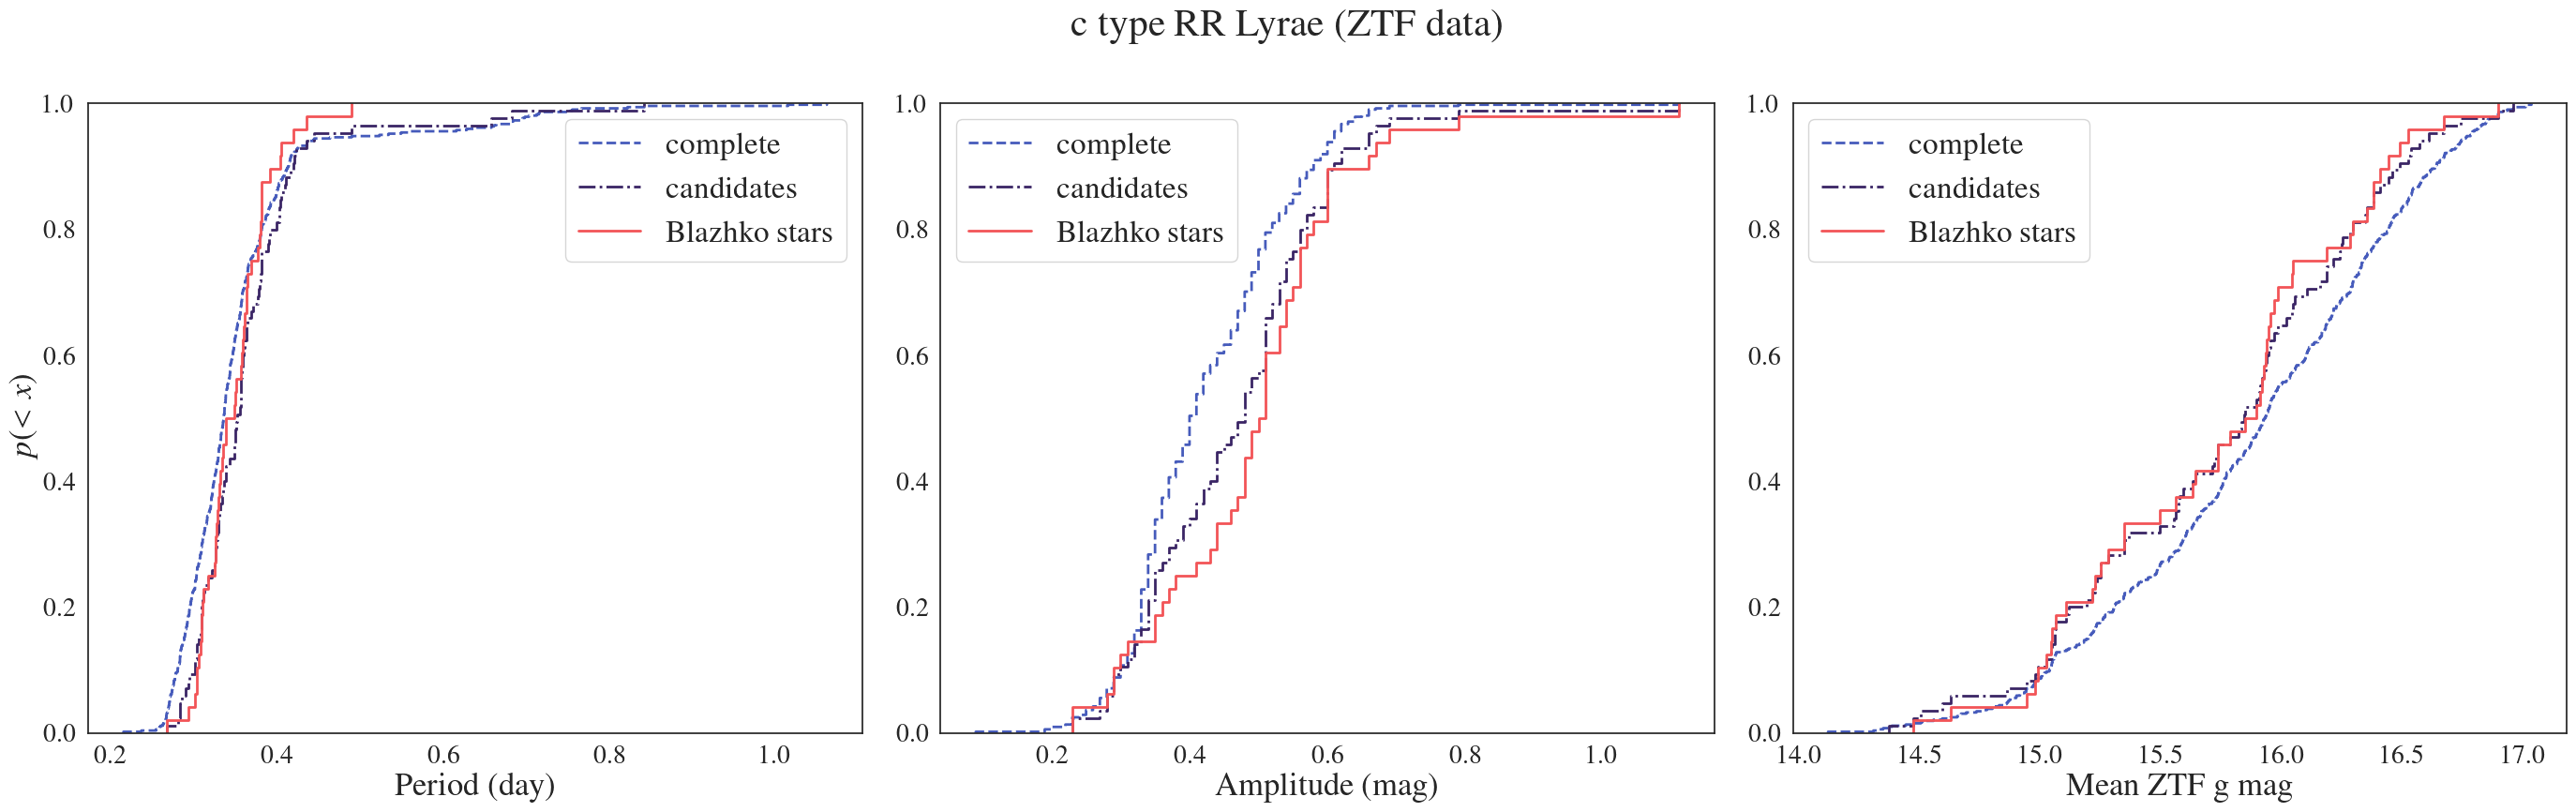

In [99]:
RRLyrType = 2
title = 'c type RR Lyrae (ZTF data)'
pAll, aAll, mAll = getCDFinputsZTF(lc_MASTERd, ztf_data, RRLyrType)
pCan, aCan, mCan = getCDFinputsZTF(b_can, ztf_data, RRLyrType)
pBlazh, aBlazh, mBlazh = getCDFinputsZTF(be_MAIN, ztf_data, RRLyrType)
plotCDFs(pAll, pCan, pBlazh, aAll, aCan, aBlazh, mAll, mCan, mBlazh, title)